In [1]:
def get_cuda_summary():
    import torch
    
    if torch.cuda.is_available():
        print('CUDA device = ', torch.cuda.get_device_name())
        print('Available number of devices = ', torch.cuda.device_count())
        print('Device numbers              = ', list(range(torch.cuda.device_count())))
        print('Current device              = ', torch.cuda.current_device())
        print(torch.cuda.memory_summary())
    else:
        print('cuda is not available')
    #torch.cuda.set_device(1)

In [2]:
#get_cuda_summary()
#do not execute this if you fit auto-pytorch model

In [53]:
!ls ..

pytorch-temp


## Data Generation
* source : COLAB `robust_multihead-3quantiles.ipynb` 
  - data point = 10000개, 분산이 증감하는 sin 함수
  - `(x,y)` : 표준화 전, `(train_x, train_y)` : 표준화 후

In [3]:
import numpy as np

N = 10000

train_x = np.random.normal(0,1,(N,)) # 표준화 된 값
x = 3*train_x+1

# Cauchy distributed error
s = np.random.standard_cauchy(N)/2

# Laplace distribution
s = np.random.laplace(size=N)

# t-distribution
s = np.random.standard_t(df = 3, size=N)

# Normal distribution
s = np.random.normal(0, 1, N)


#xmean = np.mean(x)
#xsd = np.std(x)

y = train_x/3*s*4 + np.sin(train_x/3*13)*4 + 10

ymean = np.mean(y)
ysd = np.std(y)

xmean = np.mean(x)
xsd = np.std(x)
train_y = (y-ymean)/ysd

In [4]:
%matplotlib inline

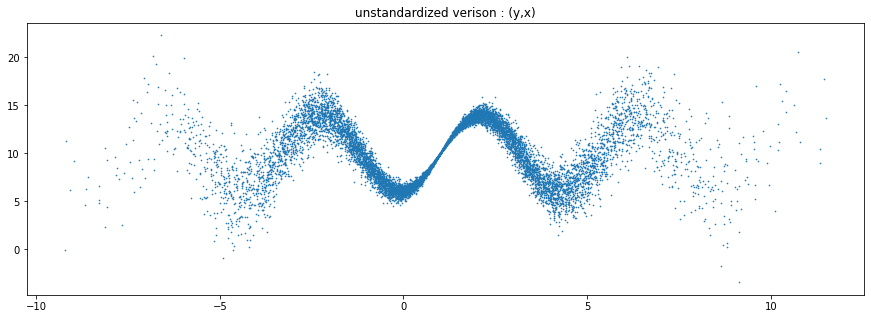

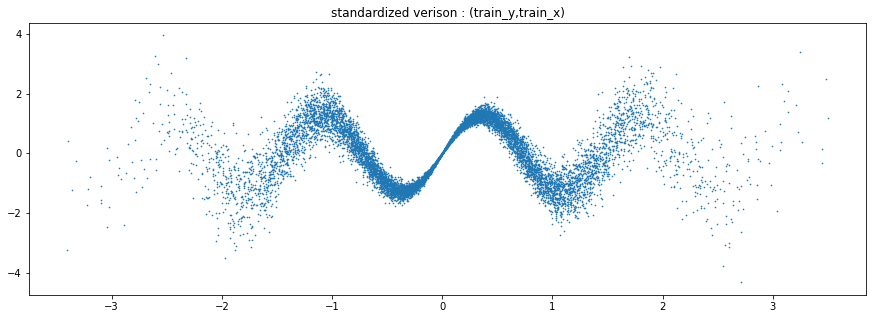

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.scatter(x, y, s=0.4)
plt.title('unstandardized verison : (y,x)')
plt.show()

plt.figure(figsize=(15,5))
plt.scatter(train_x, train_y, s=0.4)
plt.title('standardized verison : (train_y,train_x)')
plt.show()

In [6]:
import pandas as pd

import torch
from torch import nn
import os
import matplotlib.pyplot as plt

#os.environ['KMP_DUPLICATE_LIB_OK']='True'

# data = pd.read_csv('/content/02_Linear_Regression_Model_Data.csv')
# Avoid copy data, just refer
train_x_tr = torch.from_numpy(train_x.reshape([-1,1])).float()#torch.from_numpy(data['x'].values[:1000]).unsqueeze(dim=1).float()
train_y_tr = torch.from_numpy(train_y.reshape([-1,1])).float()#torch.from_numpy(data['y'].values[:1000]).unsqueeze(dim=1).float()


# AutoPyTorch 

In [7]:
from autoPyTorch import AutoNetRegression
from autoPyTorch.pipeline.nodes.loss_module_selector import  LossModuleSelector

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn.modules.loss import _Loss

class QuantileLoss2(_Loss):
    # import numpy as np
    import warnings

    __constants__ = ['reduction']

    def __init__(self, size_average=None, reduce=None, reduction='mean', ws=(0,1)):
            # size_average와 reduce는 앞으로 deprecated될 예정, reduction을 사용하라
            # reduction = 'mean' or 'sum' or 'none'
        super(QuantileLoss2, self).__init__(size_average, reduce, reduction)
        if not(isinstance(ws, tuple)) and not(isinstance(ws, np.ndarray)):
            raise ValueError('ws must be either list or np.array')
        if isinstance(ws, tuple):
            ws = np.array(ws)
        if isinstance(ws, np.ndarray) and not (len(ws.shape) == 1):
            raise ValueError('qs must be shape of 1 dim')

        self.ws = ws

    def forward(self, input, target):
        # 위의 l1_loss에서 따옴
        # l1_loss(input, target, size_average=None, reduce=None, reduction='mean')
        reduction = self.reduction
        #if not torch.jit.is_scripting():  # 뭐 하는 곳인지 모름
        #    raise ValueError('QuantileLoss: torch.jit.is_scripting() not implemented')
        #    #tens_ops = (input, target)
        #    #if any([type(t) is not Tensor for t in tens_ops]) and has_torch_function(tens_ops):
        #    #    return handle_torch_function(
        #    #        l1_loss, tens_ops, input, target, size_average=size_average, reduce=reduce,
        #    #        reduction=reduction)
        if not (target.size() == input.size()):
            warnings.warn("Using a target size ({}) that is different to the input size ({}). "
                          "This will likely lead to incorrect results due to broadcasting. "
                          "Please ensure they have the same size.".format(target.size(), input.size()),
                          stacklevel=2)
            
        ws = torch.tensor(self.ws, dtype = input.dtype, requires_grad=False).to(input.device)
        # ws : weights on quantile loss and weights on output 
        w_q = ws[0]
        w_input = ws[1:].reshape(1,-1)
        q = target[:,0:1]
        #if target.requires_grad: # 아마 target이 고정되어 있는 경우 else:에서 빠른 처리가 가능한 듯.
        if True:
            e_q = torch.abs(target[:,0]-input[:,0]) # q error, if w_q is 0, ignored
            e= target[:,1:] - input[:,1:] # target error
            
            # target[:,0:1] is q!
            ret = w_input*torch.max(q * e, (q - 1) * e)
            #ret = torch.abs(input - target) # MAE 
        if reduction != 'none':
            ret = torch.mean(ret) +torch.mean(w_q* e_q) if reduction == 'mean' else torch.sum(ret) + torch.sum(w_q*e_q)
        else:
            raise ValueError('not(target.requires_grad): not yet implemented')
            #expanded_input, expanded_target = torch.broadcast_tensors(input, target)
            #ret = torch._C._nn.l1_loss(expanded_input, expanded_target, _Reduction.get_enum(reduction))
        return ret 

ql = QuantileLoss2(ws=(0,1))


In [8]:
#yrepeats = np.repeat(y.reshape(-1,1), repeats=3, axis=1)
#train_yrepeats = np.repeat(train_y.reshape(-1,1),repeats=3, axis=1)

## 데이터 셋 `repeats`배 뻥티기

In [9]:
len(train_x.shape)

1

In [10]:
if len(train_x.shape) < 2: 
    train_x = train_x.reshape(-1,1)
if len(train_y.shape) < 2:
    train_y = train_y.reshape(-1,1)

In [11]:
repeats = 10
train_x_tr = torch.tensor(np.repeat(train_x.reshape(1,-1), repeats=repeats, axis=0).reshape(-1,train_x.shape[1]), dtype=torch.float32)
train_y_tr = torch.tensor(np.repeat(train_y.reshape(1,-1), repeats=repeats, axis=0).reshape(-1,train_y.shape[1]), dtype=torch.float32)
# 왜인지는 모르겠으나,
# Found array with 1 feature(s) (shape=(7000, 1)) while a minimum of 2 is required.

In [12]:
np.random.uniform(0,1,train_x_tr.shape[0])

array([0.04364698, 0.28945127, 0.13856445, ..., 0.61796247, 0.41030657,
       0.4196634 ])

In [13]:
1/2*np.ones(train_x_tr.shape[0])

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

In [14]:
qs = torch.tensor(np.random.uniform(0,1,train_x_tr.shape[0]), dtype=torch.float32).reshape(-1,1)
#qs = torch.tensor(1/2*np.ones(train_x_tr.shape[0]), dtype=torch.float32).reshape(-1,1)

train_x_wq = torch.cat((qs,train_x_tr), dim=1)
train_y_wq = torch.cat((qs,train_y_tr), dim=1)

In [15]:
train_x_wq[:5, :]

tensor([[ 0.8972, -1.5483],
        [ 0.6282, -1.1443],
        [ 0.5528, -0.6970],
        [ 0.1419,  1.5853],
        [ 0.6614, -0.3199]])

In [16]:
train_y_wq[:5, :]

tensor([[ 0.8972, -1.0572],
        [ 0.6282,  1.6070],
        [ 0.5528,  0.3882],
        [ 0.1419,  1.2627],
        [ 0.6614, -1.2348]])

In [17]:
train_x[:5,:]

array([[-1.54831694],
       [-1.14428905],
       [-0.69695917],
       [ 1.58528689],
       [-0.31989642]])

In [18]:
train_y[:5,:]

array([[-1.05716339],
       [ 1.6069619 ],
       [ 0.3882399 ],
       [ 1.26269616],
       [-1.23478635]])

In [19]:
#NetworkSelector:mlpnet:num_layers, Type: UniformInteger, Range: [1, 15], Default: 8
# 만약 1-4로 줄이려 한다면?

In [20]:
18000/60

300.0

In [21]:
autonet = AutoNetRegression(#"tiny_cs",  # config preset
    log_level='debug',  # epoch별로 loss를 확인할 수 있다. 
    #max_runtime=300,
    #min_budget=30,
    #max_budget=90,
    max_runtime=18000,
    min_budget = 40,
    max_budget = 180,
    #networks = ['shapedresnet'],  # mlpnet, shapedmlpnet, resnet
    #networks = ['shapedmlpnet'],
    #networks = ['mlpnet'],
    memory_limit_mb   = 12000,
    min_workers=2,
    torch_num_threads=1,
    save_models = False,
    result_logger_dir="logs/",
    shuffle=True#,
    #preprocessors = ['none'],  #['none', 'truncated_svd', 'power_transformer'],
    #normalization_strategies = ['none'], # maxabs, none, minmax, standardize
    #hyperparameter_search_space_updates=search_space_updates
)

ql = QuantileLoss2(ws=(0,1))
loss_selector = autonet.pipeline[LossModuleSelector.get_name()]
#loss_selector.add_loss_module('quantile_loss', QuantileLoss)
loss_selector.add_loss_module('quantile_loss2', ql)

/home/ubuntu/anaconda3/envs/autopytorch/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [22]:

train_x_wq.shape

torch.Size([100000, 2])

In [23]:
train_x_wq[:5,:]

tensor([[ 0.8972, -1.5483],
        [ 0.6282, -1.1443],
        [ 0.5528, -0.6970],
        [ 0.1419,  1.5853],
        [ 0.6614, -0.3199]])

In [24]:
train_x_wq[-5:,:]

tensor([[ 0.0621, -0.1628],
        [ 0.9334,  0.6082],
        [ 0.0724, -0.3042],
        [ 0.9869,  0.7631],
        [ 0.1314, -0.8530]])

In [25]:
train_y_wq[:5,:]

tensor([[ 0.8972, -1.0572],
        [ 0.6282,  1.6070],
        [ 0.5528,  0.3882],
        [ 0.1419,  1.2627],
        [ 0.6614, -1.2348]])

In [26]:
train_y_wq.shape

torch.Size([100000, 2])

In [ ]:
results_fit = autonet.fit(X_train=train_x_wq,
                          Y_train=train_y_wq,
                          loss_modules=["quantile_loss2"])
# 일단 x, y의 shape을 확인한다.
# Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

# 두 번째 실행에도, 09:43:05 Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
#Process pynisher function call:
    

19:48:59 [AutoNet] Start bohb
19:48:59 WORKER: Connected to nameserver <Pyro4.core.Proxy at 0x7fc228962400; connected IPv4; for PYRO:Pyro.NameServer@10.36.48.104:35620>
19:48:59 wait_for_workers trying to get the condition
19:48:59 DISPATCHER: started the 'discover_worker' thread
19:48:59 WORKER: No dispatcher found. Waiting for one to initiate contact.
19:48:59 DISPATCHER: started the 'job_runner' thread
19:48:59 WORKER: start listening for jobs
19:48:59 DISPATCHER: Pyro daemon running on 10.36.48.104:40682
19:48:59 DISPATCHER: Starting worker discovery
19:48:59 DISPATCHER: Found 0 potential workers, 0 currently in the pool.
19:48:59 DISPATCHER: Finished worker discovery
19:48:59 HBMASTER: only 0 worker(s) available, waiting for at least 1.
19:48:59 DISPATCHER: jobs to submit = 0, number of idle workers = 0 -> waiting!
19:49:00 DISPATCHER: A new worker triggered discover_worker
19:49:00 HBMASTER: only 0 worker(s) available, waiting for at least 1.
19:49:00 DISPATCHER: Starting worker 

The Box-Cox transformation can only be applied to strictly positive data
Using yeo-johnson instead


19:54:33 Fit: ResamplingStrategySelector
19:54:33 Fit: EmbeddingSelector
19:54:33 Fit: NetworkSelector
19:54:33 Fit: InitializationSelector
19:54:33 Fit: OptimizerSelector
19:54:33 Fit: LearningrateSchedulerSelector
19:54:33 Fit: LogFunctionsSelector
19:54:33 Fit: MetricSelector
19:54:33 Fit: LossModuleSelector
19:54:33 Fit: CreateDataLoader
19:54:33 Fit: TrainNode
19:54:33 Start train. Budget: 179.82693362236023
/home/ubuntu/anaconda3/envs/autopytorch/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:603: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
19:55:

The Box-Cox transformation can only be applied to strictly positive data
Using yeo-johnson instead


20:00:17 Fit: ResamplingStrategySelector
20:00:17 Fit: EmbeddingSelector
20:00:17 Fit: NetworkSelector
20:00:17 Fit: InitializationSelector
20:00:17 Fit: OptimizerSelector
20:00:17 Fit: LearningrateSchedulerSelector
20:00:17 Fit: LogFunctionsSelector
20:00:17 Fit: MetricSelector
20:00:17 Fit: LossModuleSelector
20:00:17 Fit: CreateDataLoader
20:00:17 Fit: TrainNode
20:00:17 Start train. Budget: 59.835267066955566
/home/ubuntu/anaconda3/envs/autopytorch/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:603: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
20:00:

The Box-Cox transformation can only be applied to strictly positive data
Using yeo-johnson instead


20:05:45 Fit: ResamplingStrategySelector
20:05:45 Fit: EmbeddingSelector
20:05:45 Fit: NetworkSelector
20:05:45 Fit: InitializationSelector
20:05:45 Fit: OptimizerSelector
20:05:45 Fit: LearningrateSchedulerSelector
20:05:45 Fit: LogFunctionsSelector
20:05:45 Fit: MetricSelector
20:05:45 Fit: LossModuleSelector
20:05:45 Fit: CreateDataLoader
20:05:45 Fit: TrainNode
20:05:45 Start train. Budget: 179.8352153301239
/home/ubuntu/anaconda3/envs/autopytorch/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:484: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
/home/ubuntu/anaconda3/envs/autopytorch/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form

The Box-Cox transformation can only be applied to strictly positive data
Using yeo-johnson instead


20:24:24 Fit: ResamplingStrategySelector
20:24:24 Fit: EmbeddingSelector
20:24:24 Fit: NetworkSelector
20:24:24 Fit: InitializationSelector
20:24:24 Fit: OptimizerSelector
20:24:24 Fit: LearningrateSchedulerSelector
20:24:24 Fit: LogFunctionsSelector
20:24:24 Fit: MetricSelector
20:24:24 Fit: LossModuleSelector
20:24:24 Fit: CreateDataLoader
20:24:24 Fit: TrainNode
20:24:24 Start train. Budget: 59.83642601966858
/home/ubuntu/anaconda3/envs/autopytorch/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:603: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
20:25:1

The Box-Cox transformation can only be applied to strictly positive data
Using yeo-johnson instead


20:25:20 Fit: ResamplingStrategySelector
20:25:20 Fit: EmbeddingSelector
20:25:20 Fit: NetworkSelector
20:25:20 Fit: InitializationSelector
20:25:20 Fit: OptimizerSelector
20:25:20 Fit: LearningrateSchedulerSelector
20:25:20 Fit: LogFunctionsSelector
20:25:20 Fit: MetricSelector
20:25:20 Fit: LossModuleSelector
20:25:20 Fit: CreateDataLoader
20:25:20 Fit: TrainNode
20:25:20 Start train. Budget: 179.83174633979797
/home/ubuntu/anaconda3/envs/autopytorch/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:603: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
20:27:

The Box-Cox transformation can only be applied to strictly positive data
Using yeo-johnson instead


20:34:01 Fit: ResamplingStrategySelector
20:34:01 Fit: EmbeddingSelector
20:34:01 Fit: NetworkSelector
20:34:01 Fit: InitializationSelector
20:34:01 Fit: OptimizerSelector
20:34:01 Fit: LearningrateSchedulerSelector
20:34:01 Fit: LogFunctionsSelector
20:34:01 Fit: MetricSelector
20:34:01 Fit: LossModuleSelector
20:34:01 Fit: CreateDataLoader
20:34:01 Fit: TrainNode
20:34:01 Start train. Budget: 59.83194899559021
/home/ubuntu/anaconda3/envs/autopytorch/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:484: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
/home/ubuntu/anaconda3/envs/autopytorch/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form

The Box-Cox transformation can only be applied to strictly positive data
Using yeo-johnson instead


20:42:18 Fit: ResamplingStrategySelector
20:42:18 Fit: EmbeddingSelector
20:42:18 Fit: NetworkSelector
20:42:18 Fit: InitializationSelector
20:42:18 Fit: OptimizerSelector
20:42:18 Fit: LearningrateSchedulerSelector
20:42:18 Fit: LogFunctionsSelector
20:42:18 Fit: MetricSelector
20:42:18 Fit: LossModuleSelector
20:42:18 Fit: CreateDataLoader
20:42:18 Fit: TrainNode
20:42:18 Start train. Budget: 179.79750752449036
/home/ubuntu/anaconda3/envs/autopytorch/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:603: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
20:42:

In [50]:
1+1

2

In [ ]:
#qs = torch.tensor((0.3)*np.ones(x_pred.shape[0]), dtype=torch.float32).reshape(-1,1)
#qs = torch.tensor(np.random.uniform(0,1,x_pred.shape[0]), dtype=torch.float32).reshape(-1,1)
#qs

#autonet.predict(torch.cat((qs,x_pred), dim=1))

In [ ]:
1+1

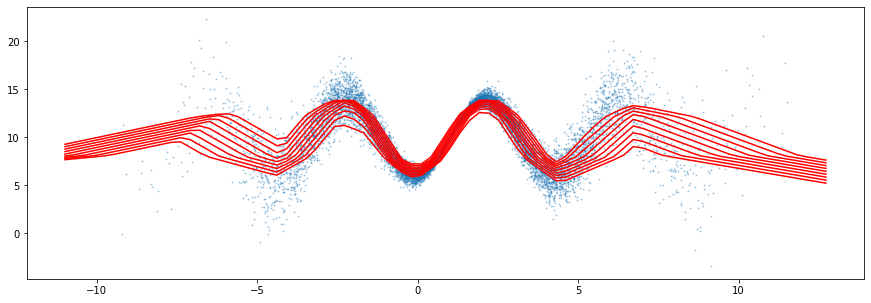

In [55]:
#modelD.eval()
plt.figure(figsize=(15,5))
plt.scatter(x, y, s=1, alpha=0.3)

for q in range(1,10,1):


    x_pred = torch.from_numpy(np.arange(-4,4,0.1).reshape([-1,1])).float()#torch.from_numpy(data['x'].values[:1000]).unsqueeze(dim=1).float()
    qs = torch.tensor((q/10)*np.ones(x_pred.shape[0]), dtype=torch.float32).reshape(-1,1)

    output = autonet.predict(torch.cat((qs,x_pred), dim=1))

    y_pred = output[:, 1:]

    x_pred2 = xsd*x_pred+xmean
    y_pred2 = ysd*y_pred+ymean

    yqs = y_pred2

    plt.plot(x_pred2, yqs[:,0], c='r')
    
#plt.savefig(fnHead+'-fit')

In [56]:
import sys, datetime

In [57]:
fnHead = str(datetime.datetime.now())[:13]

In [58]:
fnHead = 'autonet-1x1yCyclicA-'+fnHead.replace(' ', '-')

In [59]:
#fnTail = ['config.txt', ''

In [60]:
cfDict = autonet.get_current_autonet_config()

In [61]:
cfDict

{'embeddings': ['none'],
 'lr_scheduler': ['cosine_annealing', 'plateau'],
 'networks': ['shapedresnet'],
 'preprocessors': ['none', 'truncated_svd', 'power_transformer'],
 'log_level': 'debug',
 'max_runtime': 18000,
 'min_budget': 40,
 'max_budget': 180,
 'memory_limit_mb': 12000,
 'min_workers': 2,
 'torch_num_threads': 1,
 'save_models': False,
 'result_logger_dir': 'logs/',
 'shuffle': True,
 'loss_modules': ['quantile_loss2'],
 'hyperparameter_search_space_updates': None,
 'categorical_features': None,
 'dataset_name': None,
 'run_id': '0',
 'task_id': -1,
 'algorithm': 'bohb',
 'portfolio_type': 'greedy',
 'budget_type': 'time',
 'eta': 3,
 'working_dir': '.',
 'network_interface_name': 'eth0',
 'use_tensorboard_logger': False,
 'run_worker_on_master_node': True,
 'use_pynisher': True,
 'validation_split': 0.3,
 'refit_validation_split': 0.0,
 'cross_validator': 'none',
 'cross_validator_args': {},
 'min_budget_for_cv': 0,
 'imputation_strategies': ['mean', 'median', 'most_frequ

In [62]:
fnHead

'autonet-1x1yCyclicA-2020-06-12-10'

In [63]:
cfDict['hyperparameter_search_space_updates'] is None

True

In [64]:
cfDict.keys()

dict_keys(['embeddings', 'lr_scheduler', 'networks', 'preprocessors', 'log_level', 'max_runtime', 'min_budget', 'max_budget', 'memory_limit_mb', 'min_workers', 'torch_num_threads', 'save_models', 'result_logger_dir', 'shuffle', 'loss_modules', 'hyperparameter_search_space_updates', 'categorical_features', 'dataset_name', 'run_id', 'task_id', 'algorithm', 'portfolio_type', 'budget_type', 'eta', 'working_dir', 'network_interface_name', 'use_tensorboard_logger', 'run_worker_on_master_node', 'use_pynisher', 'validation_split', 'refit_validation_split', 'cross_validator', 'cross_validator_args', 'min_budget_for_cv', 'imputation_strategies', 'normalization_strategies', 'over_sampling_methods', 'under_sampling_methods', 'target_size_strategies', 'final_activation', 'initialization_methods', 'initializer', 'optimizer', 'additional_logs', 'optimize_metric', 'additional_metrics', 'batch_loss_computation_techniques', 'cuda', 'full_eval_each_epoch', 'best_over_epochs', 'predict_model', 'early_stop

In [ ]:
if cfDict['hyperparameter_search_space_updates'] is not None:
    cfDict['hyperparameter_search_space_updates'].save_as_file(fnHead + '-param_updates.txt')
#search_space_updates.save_as_file(fnHead + '-param_updates.txt')

cfDict['hyperparameter_search_space_updates'] = None

In [65]:
cfDict['hyperparameter_search_space_updates'] = None

In [ ]:
import json
with open(fnHead + "-config.json", "w") as file:
    json.dump(cfDict, file)    

In [ ]:
import json

In [ ]:
with open(fnHead + "-results_fit.json", "w") as file:
    json.dump(results_fit, file)

In [ ]:
#with open('results_fit.json') as f:
#    results_fit_json = json.load(f)

In [66]:
model  = autonet.get_pytorch_model()

In [67]:
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=337, bias=True)
  (1): Sequential(
    (0): ResBlock(
      (shortcut): Linear(in_features=337, out_features=673, bias=True)
      (start_norm): Sequential(
        (0): BatchNorm1d(337, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
      )
      (layers): Sequential(
        (0): Linear(in_features=337, out_features=673, bias=True)
        (1): BatchNorm1d(673, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=True, inplace=False)
        (4): Linear(in_features=673, out_features=673, bias=True)
      )
      (shake_shake_layers): Sequential(
        (0): Linear(in_features=337, out_features=673, bias=True)
        (1): BatchNorm1d(673, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=True, inplace=False)
        (4): Linear(in_features=673, out_features=673, bias=True)
      )
   

In [ ]:


#modelD.eval()
plt.figure(figsize=(15,5))
plt.scatter(x, y, s=1, alpha=0.3)

for q in range(1,10,1):


    x_pred = torch.from_numpy(np.arange(-4,4,0.1).reshape([-1,1])).float()#torch.from_numpy(data['x'].values[:1000]).unsqueeze(dim=1).float()
    qs = torch.tensor((q/10)*np.ones(x_pred.shape[0]), dtype=torch.float32).reshape(-1,1)

    output = autonet.predict(torch.cat((qs,x_pred), dim=1))

    y_pred = output[:, 1:]

    x_pred2 = xsd*x_pred+xmean
    y_pred2 = ysd*y_pred+ymean

    yqs = y_pred2

    plt.plot(x_pred2, yqs[:,0], c='r')
    
plt.savefig(fnHead+'-fit')


In [69]:
score_train = autonet.score(train_x_tr, train_y_tr)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 1 but corresponding boolean dimension is 2

In [70]:
import numpy as np

N = 10000

test_x = np.random.normal(0,1,(N,)) # 표준화 된 값
x = 3*test_x+1

# Cauchy distributed error
s = np.random.standard_cauchy(N)/2

# Laplace distribution
s = np.random.laplace(size=N)

# t-distribution
s = np.random.standard_t(df = 3, size=N)

# Normal distribution
s = np.random.normal(0, 1, N)


#xmean = np.mean(x)
#xsd = np.std(x)

y = test_x/3*s*4 + np.sin(test_x/3*13)*4 + 10

ymean = np.mean(y)
ysd = np.std(y)

xmean = np.mean(x)
xsd = np.std(x)
test_y = (y-ymean)/ysd

In [71]:
test_x = np.repeat(test_x.reshape(-1,1), repeats=2, axis=1)
test_y = np.repeat(test_y.reshape(-1,1), repeats=3, axis=1)

In [72]:
test_x_tr = torch.tensor(test_x, dtype=torch.float32)
test_y_tr = torch.tensor(test_y, dtype=torch.float32)

In [73]:
score_test = autonet.score(test_x_tr, test_y_tr)

ValueError: operands could not be broadcast together with shapes (10000,3) (10000,2) 

In [ ]:
with torch.no_grad():
    test_y_pred = model(test_x_tr.cuda())
    qLoss_test = ql(test_y_pred, test_y_tr.cuda()).item()

In [74]:
with torch.no_grad():
    train_y_pred = model(train_x_tr.cuda())
    qLoss_train = ql(train_y_pred, train_y_tr.cuda()).item()

model.eval()
y_pred = model(x_pred.cuda())

plt.figure(figsize=(15,5))

plt.scatter(train_x, train_y, s=1, alpha=0.2, c='black')

px = x_pred.cpu().numpy()[:,0]
plt.plot(px, y_pred[:,0].detach().cpu().numpy(), c='r')
plt.plot(px, y_pred[:,1].detach().cpu().numpy(), c='g')
plt.plot(px, y_pred[:,2].detach().cpu().numpy(), c='y')
plt.title('Loss train = '+"%5.3f" % qLoss_train + ',  test = ' + "%5.3f" % qLoss_test)

RuntimeError: size mismatch, m1: [100000 x 1], m2: [2 x 337] at /opt/conda/conda-bld/pytorch_1587428091666/work/aten/src/THC/generic/THCTensorMathBlas.cu:283

In [ ]:
plt.savefig(fnHead+'-fit')

In [ ]:
print('autonet.score : train = ', "%4.1f" % score_train, "test = %4.1f" % score_test)

In [ ]:
print('loss          : train = ', "%4.1f" % qLoss_train, "test = %4.1f" % qLoss_test)

In [ ]:
autonet.get_hyperparameter_search_space()

In [ ]:
autonet.fit_result

In [ ]:
train_x.shape

In [ ]:
train_x_tr.shape

In [54]:
1+1

2